<h2>Purpose of this notebook:</h2>

<p>This notebook will introduce you to:
<ol>
<li>using charistools to create a Hypsometry of downscaled temperatures for the Hunza basin </li>
</ol>

<p>At the end of this lesson, you should be able to create temperature Hypsometry data for which you have basin_mask tiles.</p>

<img src="../images/charistools.convertors.temperature.png">

In [1]:
%pylab notebook
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from charistools.modelEnv import ModelEnv
configFile = '/Users/brodzik/2016_Almaty_training/modis_tiles_config.ini'
topDir = '/Users/brodzik/projects/CHARIS_FTP_copy/main_training/data'
myEnv = ModelEnv(tileConfigFile=configFile, topDir=topDir, verbose=True)

/Users/brodzik/.conda/envs/pmesdr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
charistools.modelEnv: read MODIS tile configuration from /Users/brodzik/2016_Almaty_training/modis_tiles_config.ini

Populating the interactive namespace from numpy and matplotlib



charistools.modelEnv: model_top_dir changed to /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data
charistools.modelEnv: read MODIS tile configuration from /Users/brodzik/2016_Almaty_training/modis_tiles_config.ini


<p>Begin by looking at the modis_tiles_config.ini file, at the "temperature" category:</p>

In [4]:
%more $configFile

<p>You should be able to tell that we've classified temperature data as a forcing input file, and that you need a tileID and year to get a complete filename.  Also, temperature is another .h5 "tile_cube," so the charistools.readers ModisTileCube interface will be useful, but you'll need to know the variable name "varname" to tell it to read. </p>

In [5]:
tempFile = myEnv.forcing_filename(type='temperature', tileID='h24v05', year=2001)
tempFile

'/Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/temperature/ERA_Interim_downscale_mx_tsurf.v0.2.h24v05_2001.h5'

<p>For more information about these data, read the 00notes.txt file:</p>

In [ ]:
%more /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/temperature/00notes.txt

In [6]:
from netCDF4 import Dataset
f = Dataset(filename=tempFile, mode='r', format='NETCDF4')
f

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 500m

In [7]:
f.groups['500m']

<type 'netCDF4._netCDF4.Group'>
group /500m:
    dimensions(sizes): phony_dim_0(365), phony_dim_1(2400)
    variables(dimensions): uint16 tsurf(phony_dim_0,phony_dim_1,phony_dim_1)
    groups: 

<p>So the varname we want is "tsurf"</p>

In [8]:
f.close()

In [9]:
from charistools.readers import ModisTileCube
temp_cube = ModisTileCube(tempFile, varname='tsurf')
help(temp_cube)

Help on instance of ModisTileCube in module charistools.readers:

class ModisTileCube
 |  ModisTileCube class reads 3-dimensional MODIS tile .h5 data files.
 |  
 |  MODIS tile yearly cube files can be very large (2400 rows x
 |  2400 cols x 365 days).  This class provides an efficient
 |  interface for opening the cube file and only reading the tile
 |  for a specific day at a time.
 |  
 |  Public attributes:
 |  
 |  - filename: The name of the .h5 tile cube file
 |  - f: the Dataset pointer
 |  - d: the variable pointer
 |  - ndays: the number of days in the data cube
 |  - nrows: the number of rows in the data cube
 |  - ncols: the number of cols in the data cube
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename, varname, groupname='500m')
 |      Initialize a tile object to the group/variable in the file.
 |      
 |      Opens filename and creates Dataset and variable pointers to
 |      the requested variable.  Tiles for a specific day-of-year can
 |      then be 

In [10]:
temp = temp_cube.read(doy=31)
print(temp.shape)
print(np.amin(temp), np.amax(temp))

(2400, 2400)
230.0 295.09


<h3>Display one tile of the downscaled temperature data</h3>

<IPython.core.display.Javascript object>


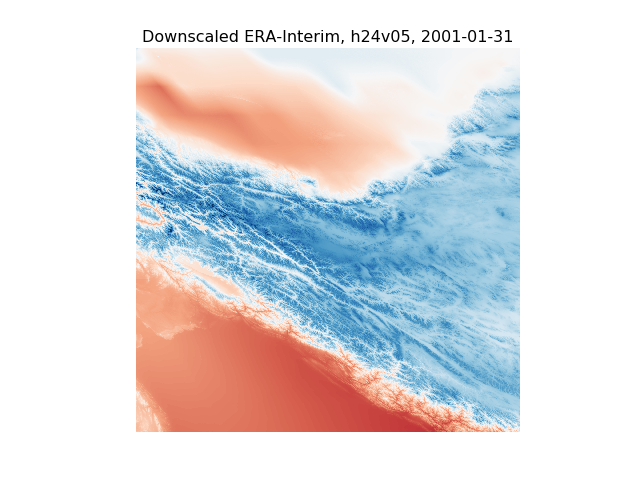

(-0.5, 2399.5, 2399.5, -0.5)

In [14]:
fig, ax = plt.subplots()
ax.imshow(temp, cmap="RdBu_r", vmin=273.15-30., vmax=273.15+30, interpolation='None')
ax.set_title('Downscaled ERA-Interim, h24v05, 2001-01-31')
plt.axis('off')

<h3>Use the charistools.convertor tool to create the temperature Hypsometry for the Hunza</h3>

<p>The charistools method to do this is "Temperature2Hypsometry".  It works like Fsca2Hypsometry and will do the tile-mosaiking for your drainageID for every date in the temperature data cube.  Where Fsca2Hypsometry calculated the fSCA area in each elevation band, Temperature2Hypsometry calculates the average temperature for each elevation band.  
</p>

<p>Temperature2Hypsometry assumes inputs are in Kelvin units, and saves the Hypsometry data in Celsius units.</p>

<p>Here is the help message:</p>

In [15]:
from charistools.convertors import Temperature2Hypsometry
help(Temperature2Hypsometry)

Help on function Temperature2Hypsometry in module charistools.convertors:

Temperature2Hypsometry(drainageID, year, modelEnv, start_doy=1, stop_doy=None, contour_m=100.0, kelvin_input=True, outfile=None, decimal_places=2, verbose=False)
    Convert raster temperature data to Hypsometry for a specific
    drainageID.
    
    Uses input ModelEnv to read temperature tiles(s) for this drainageID
    and calculates average temperature_by_elevation at the requested
    contour levels.
    
    Default start/stop_doy are dates in the temperature tile cube.
    
    Raises RuntimeError for errors reading input raster tile data.
    
    Args:
      drainageID: drainage name string to use in choosing input
        files to read, e.g. "IN_Hunza_at_Danyour" or "IN_Hunza_GDBD"
    
      year: integer, 4-digit year to use in choosing input files to
        read
    
      modelEnv: CHARIS ModelEnv object, initialized for local filesystem
    
      start_doy: integer, start day of year (1-366)
  

<p>We will use the default contour level of 100 m, and to begin, let's do 3 days at the beginning of the year.
</p>

In [17]:
temp_hyps = Temperature2Hypsometry(drainageID="IN_Hunza_at_Danyour", 
                                   year=2001, 
                                   modelEnv=myEnv, 
                                   verbose=True)

charistools.convertors : begin.
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/srtmgl3/CHARIS_DEM.v2.0.h23v05.tif
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/basin_masks/IN_Hunza_at_Danyour.basin_mask.h23v05.tif
TileID: h23v05, date: yyyydoy=2001001, yyyymmdd=20010101
TileID: h23v05, date: yyyydoy=2001002, yyyymmdd=20010102
TileID: h23v05, date: yyyydoy=2001003, yyyymmdd=20010103
TileID: h23v05, date: yyyydoy=2001004, yyyymmdd=20010104
TileID: h23v05, date: yyyydoy=2001005, yyyymmdd=20010105
TileID: h23v05, date: yyyydoy=2001006, yyyymmdd=20010106
TileID: h23v05, date: yyyydoy=2001007, yyyymmdd=20010107
TileID: h23v05, date: yyyydoy=2001008, yyyymmdd=20010108
TileID: h23v05, date: yyyydoy=2001009, yyyymmdd=20010109
TileID: h23v05, date: yyyydoy=2001010, yyyymmdd=20010110
TileID: h23v05, date: yyyydoy=2001011, yyyymmdd=20010111
TileID: h23v05, date: yyyydoy=2001012, yyyymmdd=200101

In [ ]:
temp_hyps.print()

<h3>Exercise</h3>

<p>Try running Temperature2Hypsometry for the whole year of 2001, and then use any of the Hypsometry display routines to look at the data.  Do this for drainageID="IN_Hunza_at_Danyour" or for your own basin.
</p>

<IPython.core.display.Javascript object>


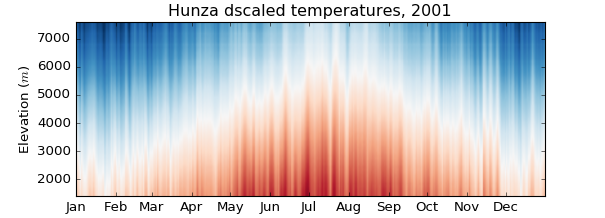

In [19]:
fig, ax = plt.subplots()
ax = temp_hyps.imshow(ax=ax, title='Hunza dscaled temperatures, 2001', 
                          cmap='RdBu_r', vmin=-40, vmax=40)
plt.show()